In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn
from pytrends.request import TrendReq
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor, SGDRegressor, TweedieRegressor 
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Flatten, Bidirectional, GRU, Conv1D, MaxPooling1D, ConvLSTM1D
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
import keras
from sklearn.decomposition import PCA

In [2]:
# originalData should be a Column Vectored DataFrame
def minmaxNorm(originalData, lenTrainValidation):
    max2norm=max(originalData.iloc[0:lenTrainValidation,0])
    min2norm=min(originalData.iloc[0:lenTrainValidation,0])
    lenOriginal=len(originalData)
    normalizedData=np.zeros(lenOriginal)   
    normalizedData = []
    for i in range (lenOriginal):
        normalizedData.append((originalData.iloc[i,0]-min2norm)/(max2norm-min2norm))    
    return pd.DataFrame(normalizedData)

In [3]:
# originalData and forecastedData should be Column Vectored DataFrames
def minmaxDeNorm( originalData, forecastedData, lenTrainValidation):
    max2norm=max(originalData.iloc[0:lenTrainValidation,0])
    min2norm=min(originalData.iloc[0:lenTrainValidation,0])
    lenOriginal=len(originalData)
    denormalizedData=[]    
    for i in range (lenOriginal):
        denormalizedData.append((forecastedData.iloc[i,0]*(max2norm-min2norm))+min2norm)  
    return pd.DataFrame(denormalizedData)

In [4]:
# split a univariate time series into patterns
def get_Patterns(TSeries, n_inputs,h):
    X,y,z = pd.DataFrame(np.zeros((len(TSeries)-n_inputs-h+1,n_inputs))), pd.DataFrame(), pd.DataFrame()
    for i in range(len(TSeries)):
        # find the end of this pattern
        end_ix = i + n_inputs + h - 1
        # check if we are beyond the time series
        if end_ix > len(TSeries)-1:
            break
        # gather input and output parts of the pattern
        for j in range(n_inputs):
            X.loc[i,j]=TSeries.iloc[i+j,0]
        i=i+n_inputs
        y=pd.concat([y,TSeries.iloc[end_ix]], ignore_index = True)
    return X,y

In [5]:
def get_multi_pattern(normalizedData1,LagLength,n_keywords):
    x = []
    k=0
    while(k<=218):
        temp=[]
        for i in range(LagLength):
            for j in range(n_keywords):
                if(i+k)<231:
                    temp.append(normalizedData1.iloc[i+k,j])
        x.append(temp)
        k=k+1
    return pd.DataFrame(x)

In [6]:
def Find_Fitness(x,y,lenValid,lenTest,model):
    NOP=y.shape[0]
    lenTrain=NOP-lenValid-lenTest
    xTrain=x.iloc[0:lenTrain,:]
    xValid=x.iloc[lenTrain:(lenTrain+lenValid),:]
    xTest=x.iloc[(lenTrain+lenValid):NOP,:]
    yTrain=y.iloc[0:lenTrain,0]
    yValid=y.iloc[lenTrain:(lenTrain+lenValid),0]
    yTest=y.iloc[(lenTrain+lenValid):NOP,0]
    model.fit(xTrain, yTrain)
    yhatNorm=model.predict(x).flatten().reshape(x.shape[0],1)
    return pd.DataFrame(yhatNorm)

In [7]:
# Timeseries_Data and forecasted_value should be Column Vectored DataFrames
def findRMSE( Timeseries_Data, forecasted_value,lenTrainValidation):
    l=Timeseries_Data.shape[0]
    lenTest=l-lenTrainValidation
    trainRMSE=0;
    for i in range (lenTrainValidation):
        trainRMSE=trainRMSE+np.power((forecasted_value.iloc[i,0]-Timeseries_Data.iloc[i,0]),2) 
    trainRMSE=np.sqrt(trainRMSE/lenTrainValidation)

    testRMSE=0;
    for i in range (lenTrainValidation,l,1):
        testRMSE=testRMSE+np.power((forecasted_value.iloc[i,0]-Timeseries_Data.iloc[i,0]),2)
    testRMSE=np.sqrt(testRMSE/lenTest)
    return trainRMSE, testRMSE 

In [8]:
# Timeseries_Data and forecasted_value should be Column Vectored DataFrames
def findSMAPE( Timeseries_Data, forecasted_value,lenTrainValidation):
    l=Timeseries_Data.shape[0]
    lenTest=l-lenTrainValidation
    trainSMAPE=0;
    for i in range (lenTrainValidation):
        trainSMAPE=trainSMAPE+(np.abs(forecasted_value.iloc[i,0]-Timeseries_Data.iloc[i,0])/((np.abs(forecasted_value.iloc[i,0])+np.abs(Timeseries_Data.iloc[i,0]))/2))
    
    trainSMAPE=(trainSMAPE/(lenTrainValidation))*100;

    testSMAPE=0;
    for i in range (lenTrainValidation,l,1):
        testSMAPE=testSMAPE+(np.abs(forecasted_value.iloc[i,0]-Timeseries_Data.iloc[i,0])/((np.abs(forecasted_value.iloc[i,0])+np.abs(Timeseries_Data.iloc[i,0]))/2))
    
    testSMAPE=(testSMAPE/lenTest)*100;
    return trainSMAPE, testSMAPE

In [9]:
# Timeseries_Data and forecasted_value should be Column Vectored DataFrames
def findMASE( Timeseries_Data, forecasted_value,lenTrainValidation):
    l=Timeseries_Data.shape[0]
    lenTest=l-lenTrainValidation
    trainMASE=0;
    T1=Timeseries_Data.iloc[0:lenTrainValidation,0]
    T2=T1.diff()
    T2=T2.drop(0)
    T2=np.abs(T2)
    M=np.mean(T2)
    for i in range (lenTrainValidation):
        trainMASE=trainMASE+(np.abs(forecasted_value.iloc[i,0]-Timeseries_Data.iloc[i,0])/M) 

    trainMASE=(trainMASE/(lenTrainValidation))

    testMASE=0
    T1=Timeseries_Data.iloc[lenTrainValidation:l,0]
    T2=T1.diff()
    T2=T2.drop(lenTrainValidation)
    T2=np.abs(T2)
    M=np.mean(T2)
    for i in range (lenTrainValidation,l,1):
        testMASE=testMASE+(np.abs(forecasted_value.iloc[i,0]-Timeseries_Data.iloc[i,0])/M)
    testMASE=(testMASE/lenTest)
    return trainMASE,testMASE 

In [10]:
# Timeseries_Data and forecasted_value should be Column Vectored DataFrames
def findMAE( Timeseries_Data, forecasted_value,lenTrainValidation):
    l=Timeseries_Data.shape[0]
    lenTest=l-lenTrainValidation
    trainMAE=0;
    for i in range (lenTrainValidation):
        trainMAE=trainMAE+np.abs(forecasted_value.iloc[i,0]-Timeseries_Data.iloc[i,0]) 
    trainMAE=(trainMAE/(lenTrainValidation));

    testMAE=0;
    for i in range (lenTrainValidation,l,1):
        testMAE=testMAE+np.abs(forecasted_value.iloc[i,0]-Timeseries_Data.iloc[i,0])
    testMAE=(testMAE/lenTest);
    return trainMAE, testMAE

In [11]:
def Find_Fitness_LSTM1(x,y,lenValid,lenTest):
    NOP=len(y);   
    lenTrain=NOP-lenValid-lenTest
    xTrain=x.iloc[0:lenTrain,:]
    xValid=x.iloc[lenTrain:(lenTrain+lenValid),:]
    xTest=x.iloc[(lenTrain+lenValid):NOP,:]
    yTrain=y.iloc[0:lenTrain,0]
    yValid=y.iloc[lenTrain:(lenTrain+lenValid),0]
    yTest=y.iloc[(lenTrain+lenValid):NOP,0]
    model1 = Sequential()
    model1.add(LSTM(256, activation='tanh', input_shape=(LagLength,n_features), name="feature_layer"))
    model1.add(Flatten())
    model1.add(Dense(128, activation='relu'))
    model1.add(Dense(64, activation='relu'))
    model1.add(Dense(32, activation='relu'))
    model1.add(Dense(16, activation='relu'))
    model1.add(Dense(1,activation='linear'))
    cp1=ModelCheckpoint('./model1.keras',save_best_only='True')
    model1.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.01),metrics=[RootMeanSquaredError(),MeanAbsolutePercentageError()])
    # fit
    model1.fit(xTrain, yTrain,validation_data=(xValid,yValid), epochs=50, verbose=1,callbacks=[cp1])
    yhatNorm=model1.predict(x).flatten().reshape(x.shape[0],1)
    feature_extractor = keras.Model(inputs=model1.inputs, outputs=model1.get_layer(name="feature_layer").output,)
    features = feature_extractor(x.values.reshape(x.shape[0],x.shape[1],1))
    return pd.DataFrame(yhatNorm), pd.DataFrame(features)

In [12]:
#Read the Time Series Dataset
from pytrends.request import TrendReq
Timeseries_Data=pd.read_csv('crude_oil_prices.csv',header=None)
#Get the google trends dataset

In [13]:
Timeseries_Data.head()

,0,1
0,31.37,Jan-04
1,31.33,Feb-04
2,33.67,Mar-04
3,33.71,Apr-04
4,37.56,May-04


In [15]:
Timeseries_Data.tail()

,0,1
226,87.38,Nov-22
227,78.07,Dec-22
228,80.41,Jan-23
229,80.25,Feb-23
230,76.47,Mar-23


In [16]:
LagLength=12
h=1
n_features = 1
n_keywords = 4
NumberOfRepeatitions=20

In [17]:
lt=Timeseries_Data.shape[0]
lenTrain=int(round(lt*0.6))
lenValidation=int(round(lt*0.2))
lenTest=int(lt-lenTrain-lenValidation)
print((Timeseries_Data.shape))

(231, 2)


In [18]:
# NORMALIZE THE DATA
normalizedData=minmaxNorm(Timeseries_Data,lenTrain+lenValidation);
# Transform the Time Series into Patterns Using Sliding Window
X1, y1 = get_Patterns(normalizedData, LagLength, h)
#apply the data to train lstm and extract features

print(X1.shape)
print(y1.shape)

(219, 12)
(219, 1)


In [19]:
lstm_predict,features=Find_Fitness_LSTM1(X1,y1,lenValidation,lenTest)
#remove empty columns/features
truncated_features = features.loc[:,(features!=0).any(axis=0)]
#reduce dimensionality using pca
pca1 = PCA(n_components=4)
final_features_hist = pca1.fit_transform(truncated_features.values)
final_features_hist = pd.DataFrame(final_features_hist)

C:\Users\lohit\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 726ms/step - loss: 11.2536 - mean_absolute_percentage_error: 437.9921 - root_mean_squared_error: 2.7837 - val_loss: 0.0470 - val_mean_absolute_percentage_error: 993104.5000 - val_root_mean_squared_error: 0.2168
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.2038 - mean_absolute_percentage_error: 81.3395 - root_mean_squared_error: 0.4500 - val_loss: 0.0143 - val_mean_absolute_percentage_error: 3602538.0000 - val_root_mean_squared_error: 0.1194
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - loss: 0.0742 - mean_absolute_percentage_error: 57.8787 - root_mean_squared_error: 0.2716 - val_loss: 0.0100 - val_mean_absolute_percentage_error: 5718656.0000 - val_root_mean_squared_error: 0.1001
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0619 - mean_absolute_percentage_error: 45.5953 - root_mean_squared_error: 0.2480 - val_loss: 0.0149 - val_mean_absolute_percentage_error: 6467870.0000 - val_root_mean_squared_error: 0.1220
Epoc

In [22]:
MeanAccuracyT=pd.DataFrame()
StdAccuracyT=pd.DataFrame()

In [23]:
for j in range(0,20,1):
    print('Model:::::::::::::::::::::::::::::::',j)
    if j==0:
        model=LinearRegression()
        name='1.LinearRegression'
    elif j==1:
        model=Lasso()
        name='2.Lasso'
    elif j==2:
        model=Ridge()
        name='3.Ridge'
    elif j==3:
        model=ElasticNet()
        name='4.ElasticNet'
    elif j==4:
        model=HuberRegressor(max_iter=1000)
        name='5.HuberRegressor'
    elif j==5:
        model=SGDRegressor()
        name='6.SGDRegressor'
    elif j==6:
        model=TweedieRegressor()
        name='7.TweedieRegressor'
    elif j==7:
        model=AdaBoostRegressor()
        name='8.AdaBoostRegressor'
    elif j==8:
        model=RandomForestRegressor()
        name='9.RandomForestRegressor'
    elif j==9:
        model=GradientBoostingRegressor()
        name='10.GradientBoostingRegressor'
    elif j==10:
        model=LinearSVR()
        name='11.LinearSVR'
    elif j==11:
        model=MLPRegressor()
        name='12.MLP'
    elif j==12:
        model=SVR()
        name='13.SVR'
    elif j==13:
        model=ExtraTreesRegressor()
        name='14.ExtraTreesRegressor'
    elif j==14:
        model=BaggingRegressor()
        name='15.BaggingRegressor'
    elif j==15:
        model=DecisionTreeRegressor()
        name='16.DecisionTreeRegressor'
    elif j==16:
        model=KNeighborsRegressor()
        name='17.KNeighborsRegressor'
    elif j==17:
        model=model_xgb = xgb.XGBRegressor(verbosity=0)
        name='18.XGB'
    elif j==18:
        model=StackingRegressor(estimators=[('lr',LinearRegression()),('xgb',xgb.XGBRegressor(verbosity=0))],final_estimator=LinearRegression())
        name='19.Stacking'

    else:
        print('Completed.....................')
        continue
    file1='./'+str(name)+"_Accuracy.xlsx"
    file2='./'+str(name)+"_Forecasts.xlsx"
    Forecasts=pd.DataFrame()
    Accuracy=pd.DataFrame()
    for i in range(NumberOfRepeatitions):
        print('No. of repeatitions completed:',i)
        ynorm1=Find_Fitness(final_features_hist,y1,lenValidation,lenTest,model)
        ynorm=pd.DataFrame(normalizedData.iloc[0:(LagLength+h-1),0])
        ynorm=pd.concat([ynorm,ynorm1],ignore_index = True)
        yhat=minmaxDeNorm(Timeseries_Data, ynorm, lenTrain+lenValidation)
        Accuracy.loc[i,0],Accuracy.loc[i,1]=findRMSE( Timeseries_Data,yhat,lenTrain+lenValidation)
        Accuracy.loc[i,2],Accuracy.loc[i,3]=findSMAPE( Timeseries_Data,yhat,lenTrain+lenValidation)
        Accuracy.loc[i,4],Accuracy.loc[i,5]=findMAE( Timeseries_Data,yhat,lenTrain+lenValidation)
        Accuracy.loc[i,6],Accuracy.loc[i,7]=findMASE( Timeseries_Data,yhat,lenTrain+lenValidation)
        Forecasts=pd.concat([Forecasts,yhat.T],ignore_index = True)
    Accuracy.to_excel(file1,sheet_name='Accuracy',index=False)
    Forecasts.T.to_excel(file2,sheet_name='Forecasts',index=False)
    MeanAccuracy=pd.DataFrame(np.mean(Accuracy,axis=0))    
    MeanAccuracyT=pd.concat([MeanAccuracyT,MeanAccuracy.T], ignore_index = True)
    StdAccuracy=pd.DataFrame(np.std(Accuracy,axis=0))    
    StdAccuracyT=pd.concat([StdAccuracyT,StdAccuracy.T], ignore_index = True)
    del Accuracy
    del Forecasts
    del MeanAccuracy
    del StdAccuracy
MeanAccuracyT.to_excel('All_Model_Mean_Accuracy.xlsx',sheet_name='All_Model_Accuracy',index=False)
del MeanAccuracyT
StdAccuracyT.to_excel('All_Model_Stdev_Accuracy.xlsx',sheet_name='All_Model_Stdev_Accuracy',index=False)
del StdAccuracyT

Model::::::::::::::::::::::::::::::: 0
No. of repeatitions completed: 0
No. of repeatitions completed: 1
No. of repeatitions completed: 2
No. of repeatitions completed: 3
No. of repeatitions completed: 4
No. of repeatitions completed: 5
No. of repeatitions completed: 6
No. of repeatitions completed: 7
No. of repeatitions completed: 8
No. of repeatitions completed: 9
No. of repeatitions completed: 10
No. of repeatitions completed: 11
No. of repeatitions completed: 12
No. of repeatitions completed: 13
No. of repeatitions completed: 14
No. of repeatitions completed: 15
No. of repeatitions completed: 16
No. of repeatitions completed: 17
No. of repeatitions completed: 18
No. of repeatitions completed: 19
Model::::::::::::::::::::::::::::::: 1
No. of repeatitions completed: 0
No. of repeatitions completed: 1
No. of repeatitions completed: 2
No. of repeatitions completed: 3
No. of repeatitions completed: 4
No. of repeatitions completed: 5
No. of repeatitions completed: 6
No. of repeatitions c

C:\Users\lohit\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


No. of repeatitions completed: 14
No. of repeatitions completed: 15
No. of repeatitions completed: 16
No. of repeatitions completed: 17
No. of repeatitions completed: 18
No. of repeatitions completed: 19
Model::::::::::::::::::::::::::::::: 11
No. of repeatitions completed: 0
No. of repeatitions completed: 1
No. of repeatitions completed: 2
No. of repeatitions completed: 3
No. of repeatitions completed: 4
No. of repeatitions completed: 5
No. of repeatitions completed: 6
No. of repeatitions completed: 7
No. of repeatitions completed: 8
No. of repeatitions completed: 9
No. of repeatitions completed: 10
No. of repeatitions completed: 11
No. of repeatitions completed: 12
No. of repeatitions completed: 13
No. of repeatitions completed: 14
No. of repeatitions completed: 15
No. of repeatitions completed: 16
No. of repeatitions completed: 17
No. of repeatitions completed: 18
No. of repeatitions completed: 19
Model::::::::::::::::::::::::::::::: 12
No. of repeatitions completed: 0
No. of repeat

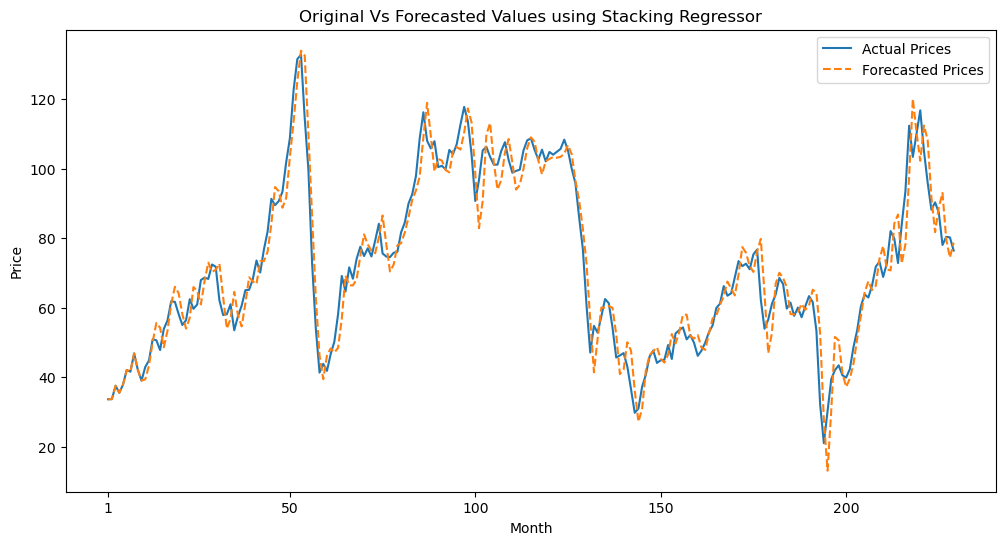

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df_a = pd.read_excel('19.Stacking_Forecasts.xlsx')
df_b = pd.read_csv("crude_oil_prices.csv")

# Select specific rows
df_a_selected = df_a.iloc[2:232]
df_b_selected = df_b.iloc[1:231]

# Extract x and y values for plotting
x_values = df_b_selected.iloc[:, 1]  # Assuming the second column is the month
y_values_actual = df_b_selected.iloc[:, 0]  # Assuming the first column is the actual prices
y_values_forecast = df_a_selected.iloc[:, 0]  # Assuming the first column is the forecasted prices

plt.figure(figsize=(12, 6))  # Width: 12, Height: 6

# Increase figure size
# Plot the data
plt.plot(x_values, y_values_actual, label='Actual Prices')
plt.plot(x_values, y_values_forecast, label='Forecasted Prices', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Month')
plt.ylabel('Price')
plt.title('Original Vs Forecasted Values using Stacking Regressor')
plt.legend()

# Set specific x-axis tick locations and labels
tick_locations = [0, 49, 99, 149, 199]
tick_labels = ['1', '50', '100', '150', '200']
plt.xticks(tick_locations, tick_labels)

# Display the plot
plt.show()

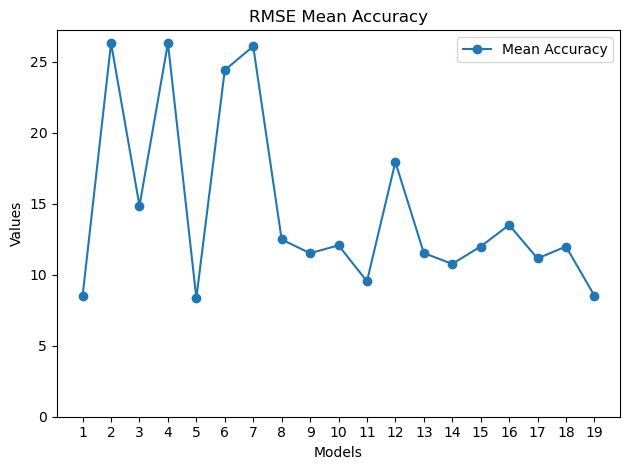

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from the Excel file
df_a = pd.read_excel('All_Model_Mean_Accuracy.xlsx')

# Create an x-axis array ranging from 1 to 19
x = list(range(1, 20))

# List of model names
model_names = [
    'LinearRegression', 'Lasso', 'Ridge', 'ElasticNet', 'HuberRegressor',
    'SGDRegressor', 'TweedieRegressor', 'AdaBoostRegressor', 'RandomForestRegressor',
    'GradientBoostingRegressor', 'LinearSVR', 'MLPRegressor', 'SVR',
    'ExtraTreesRegressor', 'BaggingRegressor', 'DecisionTreeRegressor',
    'KNeighborsRegressor', 'XGBRegressor', 'StackingRegressor'
]

# Plot the data
# Assuming the 2nd column of the Excel sheet contains the values to be plotted
plt.plot(x, df_a.iloc[:, 1], marker='o', linestyle='-', label='Mean Accuracy')

# Add titles and labels
plt.title('RMSE Mean Accuracy')
plt.xlabel('Models')
plt.ylabel('Values')
plt.xticks(ticks=x)
plt.ylim(bottom=0)  # Start y-axis from 0
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


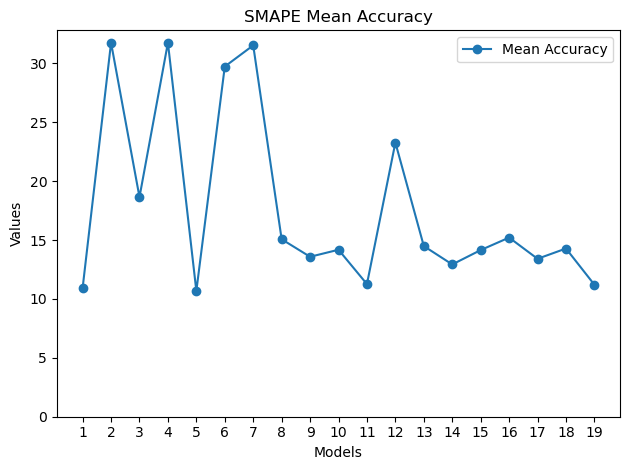

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from the Excel file
df_a = pd.read_excel('All_Model_Mean_Accuracy.xlsx')

# Create an x-axis array ranging from 1 to 19
x = list(range(1, 20))

# List of model names
model_names = [
    'LinearRegression', 'Lasso', 'Ridge', 'ElasticNet', 'HuberRegressor',
    'SGDRegressor', 'TweedieRegressor', 'AdaBoostRegressor', 'RandomForestRegressor',
    'GradientBoostingRegressor', 'LinearSVR', 'MLPRegressor', 'SVR',
    'ExtraTreesRegressor', 'BaggingRegressor', 'DecisionTreeRegressor',
    'KNeighborsRegressor', 'XGBRegressor', 'StackingRegressor'
]

# Plot the data
# Assuming the 2nd column of the Excel sheet contains the values to be plotted
plt.plot(x, df_a.iloc[:, 3], marker='o', linestyle='-', label='Mean Accuracy')

# Add titles and labels
plt.title('SMAPE Mean Accuracy')
plt.xlabel('Models')
plt.ylabel('Values')
plt.xticks(ticks=x)
plt.ylim(bottom=0)  # Start y-axis from 0

plt.legend()

# Show the plot
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


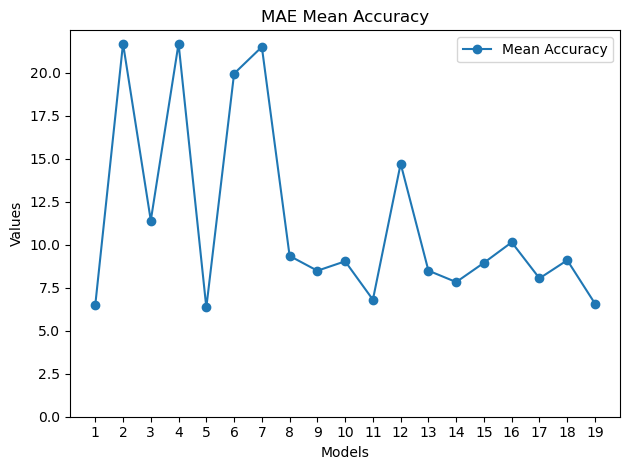

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from the Excel file
df_a = pd.read_excel('All_Model_Mean_Accuracy.xlsx')

# Create an x-axis array ranging from 1 to 19
x = list(range(1, 20))

# List of model names
model_names = [
    'LinearRegression', 'Lasso', 'Ridge', 'ElasticNet', 'HuberRegressor',
    'SGDRegressor', 'TweedieRegressor', 'AdaBoostRegressor', 'RandomForestRegressor',
    'GradientBoostingRegressor', 'LinearSVR', 'MLPRegressor', 'SVR',
    'ExtraTreesRegressor', 'BaggingRegressor', 'DecisionTreeRegressor',
    'KNeighborsRegressor', 'XGBRegressor', 'StackingRegressor'
]

# Plot the data
# Assuming the 2nd column of the Excel sheet contains the values to be plotted
plt.plot(x, df_a.iloc[:, 5], marker='o', linestyle='-', label='Mean Accuracy')

# Add titles and labels
plt.title('MAE Mean Accuracy')
plt.xlabel('Models')
plt.ylabel('Values')
plt.ylim(bottom=0)  # Start y-axis from 0
plt.xticks(ticks=x)
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


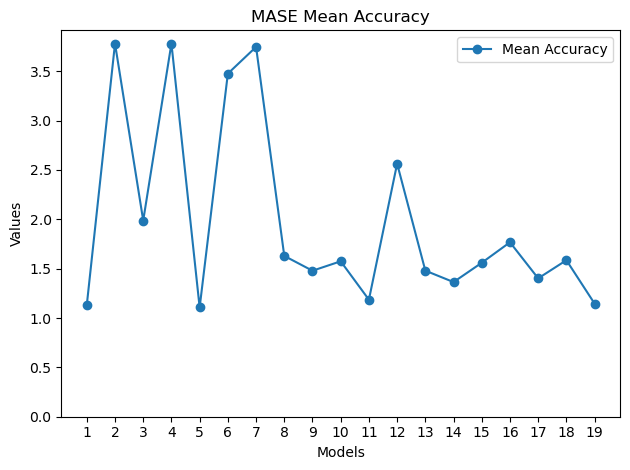

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from the Excel file
df_a = pd.read_excel('All_Model_Mean_Accuracy.xlsx')

# Create an x-axis array ranging from 1 to 19
x = list(range(1, 20))

# List of model names
model_names = [
    'LinearRegression', 'Lasso', 'Ridge', 'ElasticNet', 'HuberRegressor',
    'SGDRegressor', 'TweedieRegressor', 'AdaBoostRegressor', 'RandomForestRegressor',
    'GradientBoostingRegressor', 'LinearSVR', 'MLPRegressor', 'SVR',
    'ExtraTreesRegressor', 'BaggingRegressor', 'DecisionTreeRegressor',
    'KNeighborsRegressor', 'XGBRegressor', 'StackingRegressor'
]

# Plot the data
# Assuming the 2nd column of the Excel sheet contains the values to be plotted
plt.plot(x, df_a.iloc[:, 7], marker='o', linestyle='-', label='Mean Accuracy')

# Add titles and labels
plt.title('MASE Mean Accuracy')
plt.xlabel('Models')
plt.ylabel('Values')
plt.ylim(bottom=0)  # Start y-axis from 0
plt.xticks(ticks=x)
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust layout to fit labels
plt.show()
